In [315]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

import os
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import pandas as pd
from torch.autograd import Variable

In [316]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [317]:
header = ['title', 'address', 'unit_type', 'price', 'bedrooms', 'bathrooms', 'apartment_lat', 'apartment_lon', 'hydro_included', 'heat_included', 'water_included', 'laundry_included', 'backyard_included', 'parking_included', 'gym_included', 'sqft', 'furnished', 'air_conditioning', 'walk_score', 'transit_score', 'bike_score', 'img_1', 'img_2', 'img_3']
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/scraped_ads.csv", names=header, index_col=False)

In [318]:
df = df[1:]
df = df[["unit_type", "price", "bedrooms", "bathrooms", "apartment_lat", "apartment_lon", "hydro_included", "heat_included", "water_included", "laundry_included", "backyard_included", "parking_included", "gym_included", "sqft", "furnished", "air_conditioning", "walk_score", "transit_score", "bike_score"]]
df = pd.get_dummies(df, columns=["unit_type"]) # one-hot unit_type
# to numeric
df["price"] = pd.to_numeric(df.price)
df["bedrooms"] = pd.to_numeric(df.bedrooms)
df["bathrooms"] = pd.to_numeric(df.bathrooms)
df["apartment_lat"] = pd.to_numeric(df.apartment_lat)
df["apartment_lon"] = pd.to_numeric(df.apartment_lon)
df["sqft"] = pd.to_numeric(df.sqft)
df["walk_score"] = pd.to_numeric(df.walk_score)
df["transit_score"] = pd.to_numeric(df.transit_score)
df["bike_score"] = pd.to_numeric(df.bike_score)
# get rid of outliers for lat/long/sqft
for index, row in df.iterrows():
    if(row['apartment_lat'] > 45):
      df.at[index, "apartment_lat"] = pd.NA
    if(row['apartment_lat'] < 43):
      df.at[index, "apartment_lat"] = pd.NA
    if(row['apartment_lon'] > -75):
      df.at[index, "apartment_lon"] = pd.NA
    if(row['apartment_lon'] < -80):
      df.at[index, "apartment_lon"] = pd.NA
    if(row["sqft"] < 50):
      df.at[index, "sqft"] = pd.NA
    if(row["sqft"] > 3000):
      df.at[index, "sqft"] = pd.NA
    #DELETE AFTER
    if(row['bedrooms'] > 2):
      df.at[index, "apartment_lat"] = pd.NA
    #DELETE AFTER
df = df.dropna()
# normalize
#df["price"] = (df["price"] - df["price"].min()) /(df["price"].max() - df["price"].min()) # normalize price
df["bedrooms"] = (df["bedrooms"] - df["bedrooms"].min()) /(df["bedrooms"].max() - df["bedrooms"].min()) # normalize bedrooms
df["bathrooms"] = (df["bathrooms"] - df["bathrooms"].min()) /(df["bathrooms"].max() - df["bathrooms"].min()) # normalize bathrooms
df["apartment_lat"] = (df["apartment_lat"] - df["apartment_lat"].min()) /(df["apartment_lat"].max() - df["apartment_lat"].min()) # normalize apartment_lat
df["apartment_lon"] = (df["apartment_lon"] - df["apartment_lon"].min()) /(df["apartment_lon"].max() - df["apartment_lon"].min()) # normalize apartment_lon
df["sqft"] = (df["sqft"] - df["sqft"].min()) /(df["sqft"].max() - df["sqft"].min()) # normalize sqft
df["walk_score"] = (df["walk_score"] - df["walk_score"].min()) /(df["walk_score"].max() - df["walk_score"].min()) # normalize walk_score
df["transit_score"] = (df["transit_score"] - df["transit_score"].min()) /(df["transit_score"].max() - df["transit_score"].min()) # normalize transit_score
df["bike_score"] = (df["bike_score"] - df["bike_score"].min()) /(df["bike_score"].max() - df["bike_score"].min()) # normalize transit_score
print(df)
datanp = df.values.astype(np.float32)

      price  bedrooms  ...  unit_type_House unit_type_Not Available
1    1350.0       0.0  ...                0                       0
2    1100.0       0.0  ...                0                       0
3    1292.0       0.0  ...                0                       0
5    2100.0       1.0  ...                0                       0
9    2057.0       0.5  ...                0                       0
..      ...       ...  ...              ...                     ...
722  1949.0       0.0  ...                0                       0
723  1199.0       0.0  ...                0                       0
724  1650.0       0.0  ...                0                       0
725  2700.0       1.0  ...                0                       0
726  2850.0       1.0  ...                0                       0

[630 rows x 24 columns]


In [319]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
np.random.shuffle(datanp)

train_index = int(datanp.shape[0] * 0.7)
val_index = int(datanp.shape[0] * 0.85)

#train_set = datanp

#
train_set = datanp[:train_index]
val_set = datanp[train_index:val_index]
test_set = datanp[val_index:]

print("# Train Set: " + str(train_set.shape[0]))
print("# Test Set: " + str(val_set.shape[0]))
print("# Val Set: " + str(test_set.shape[0]))

# Train Set: 441
# Test Set: 94
# Val Set: 95


In [320]:
class Test_ANN(nn.Module):
    def __init__(self):
        super(Test_ANN, self).__init__()
        self.name = "test_ann"
        self.layer1 = nn.Linear(23, 10)
        self.layer2 = nn.Linear(10, 1)
    def forward(self, img):
        #flattened = img.view(-1, 17)
        activation1 = self.layer1(img)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2

In [321]:
class Test_ANN_Another(nn.Module):
    def __init__(self):
        super(Test_ANN_Another, self).__init__()
        self.name = "test_ann"
        self.layer1 = nn.Linear(23, 18)
        self.layer2 = nn.Linear(18, 10)
        self.layer3 = nn.Linear(10, 1)
    def forward(self, img):
        activation1 = self.layer1(img)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = F.relu(activation2)
        activation3 = self.layer3(activation2)
        return activation3

In [322]:
x_train = train_set[:,1:]
print(x_train)
x_train = x_train.reshape(-1, 23)

y_train = train_set[:,0]
y_train = y_train.reshape(-1, 1)


train_data = []
for i in range(len(x_train)):
   train_data.append([x_train[i], y_train[i]])

#print(train_data)
trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=32)
i1, l1 = next(iter(trainloader))
#for things in i1:
#  print(things)
#for thingss in l1:
  #print(thingss)


[[0.         0.         0.42186633 ... 0.         0.         0.        ]
 [1.         0.         0.4047097  ... 0.         0.         0.        ]
 [0.         0.         0.36490816 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.34776443 ... 0.         0.         0.        ]
 [0.         0.         0.39256144 ... 0.         0.         0.        ]
 [0.         0.         0.38117093 ... 0.         0.         0.        ]]


In [323]:
def train(model, train_loader, num_epochs=5, learning_rate=1e-4, batch_size=64):
    """ Training loop. You should update this."""

    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    #train_acc, val_acc = [], []
    epochs, losses = [], []
    for epoch in range(num_epochs):
      for data, labels in train_loader:
            recon = model(data)
            loss = criterion(recon, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
      print('epoch {}, loss {}'.format(epoch, loss.item()))

      epochs.append(epoch)
      losses.append(float(loss))
        #train_acc.append(get_accuracy(model, train_loader))
        #val_acc.append(get_accuracy(model, valid_loader))
        #model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        #torch.save(model.state_dict(), model_path)
        #print(epoch, train_acc[-1], val_acc[-1])
        #print("epoch: ", epoch, end = " ")
        #print("train acc: ", get_accuracy(model, train_loader), end = " ")
        #print("val acc: ", get_accuracy(model, valid_loader))

    return epochs, losses

epoch 0, loss 3413836.5
epoch 1, loss 3869376.75
epoch 2, loss 4406463.5
epoch 3, loss 2596620.5
epoch 4, loss 2795340.75
epoch 5, loss 1378620.0
epoch 6, loss 211331.046875
epoch 7, loss 309562.625
epoch 8, loss 257020.265625
epoch 9, loss 239229.0625
epoch 10, loss 774640.625
epoch 11, loss 219924.921875
epoch 12, loss 186019.3125
epoch 13, loss 356949.03125
epoch 14, loss 190837.0
epoch 15, loss 420257.09375
epoch 16, loss 141736.703125
epoch 17, loss 198982.578125
epoch 18, loss 162742.28125
epoch 19, loss 134233.6875
epoch 20, loss 668067.5
epoch 21, loss 104989.0078125
epoch 22, loss 67709.9921875
epoch 23, loss 58015.03125
epoch 24, loss 114697.359375
epoch 25, loss 584663.25
epoch 26, loss 158350.71875
epoch 27, loss 99412.40625
epoch 28, loss 102035.9921875
epoch 29, loss 254547.5
epoch 30, loss 191294.265625
epoch 31, loss 125781.203125
epoch 32, loss 91880.0234375
epoch 33, loss 185717.6875
epoch 34, loss 117598.6796875
epoch 35, loss 102164.03125
epoch 36, loss 222702.48437

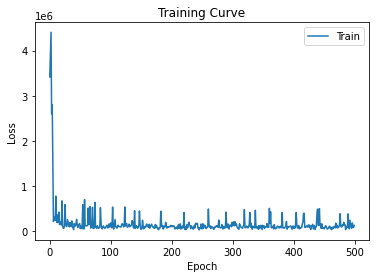

In [324]:
#batch_size=1
#train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)
#valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)

model_1 = Test_ANN()
epochs, losses = train(model_1, trainloader, num_epochs=500, learning_rate=1e-6, batch_size=1)

plt.title("Training Curve")
plt.plot(losses, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

epoch 0, loss 3414298.0
epoch 1, loss 3869861.0
epoch 2, loss 4401454.5
epoch 3, loss 1817369.125
epoch 4, loss 739553.375
epoch 5, loss 174753.78125
epoch 6, loss 111224.703125
epoch 7, loss 189647.90625
epoch 8, loss 82032.546875
epoch 9, loss 93034.5703125
epoch 10, loss 466943.84375
epoch 11, loss 139162.09375
epoch 12, loss 97855.84375
epoch 13, loss 250490.140625
epoch 14, loss 85273.7421875
epoch 15, loss 273722.90625
epoch 16, loss 108853.25
epoch 17, loss 134207.15625
epoch 18, loss 90520.2734375
epoch 19, loss 107787.328125
epoch 20, loss 533270.125
epoch 21, loss 105497.0703125
epoch 22, loss 47508.4296875
epoch 23, loss 39565.88671875
epoch 24, loss 104844.5078125
epoch 25, loss 484240.71875
epoch 26, loss 103337.328125
epoch 27, loss 75263.015625
epoch 28, loss 68598.578125
epoch 29, loss 234440.296875
epoch 30, loss 175464.5
epoch 31, loss 97392.7421875
epoch 32, loss 73467.34375
epoch 33, loss 139579.953125
epoch 34, loss 159265.234375
epoch 35, loss 160828.015625
epoch 

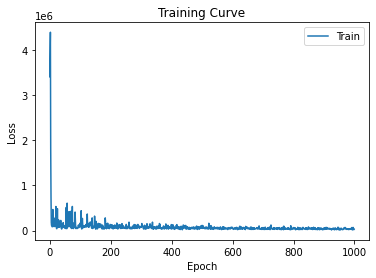

In [325]:
#batch_size=1
#train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)
#valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)

model_2 = Test_ANN_Another()
epochs, losses = train(model_2, trainloader, num_epochs=1000, learning_rate=1e-6, batch_size=1)

plt.title("Training Curve")
plt.plot(losses, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

In [326]:
x_test = test_set[:,1:]
x_test = x_test.reshape(-1, 23)

y_test = test_set[:,0]
y_test = y_test.reshape(-1, 1)

[1472.0809] [1450.]
[1432.3469] [1450.]
[2268.3772] [2250.]
[2041.4025] [2057.]
[2176.856] [2150.]
[2115.2717] [2100.]
[1488.5685] [1500.]
[1962.6942] [1949.]
[2036.705] [2057.]
[2717.0493] [2690.]


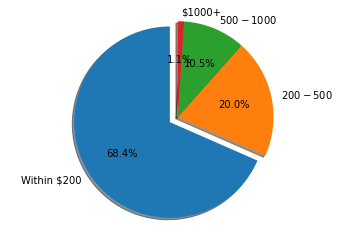

In [329]:
with torch.no_grad(): # we don't need gradients in the testing phase
    predicted_s = model_2(Variable(torch.from_numpy(x_test))).data.numpy()

e_0 = 0
e_1 = 0
e_2 = 0
e_3 = 0

for i in range(len(predicted_s)):
    if (abs(y_test[i]-predicted_s[i]) <= 50):
      print(predicted_s[i], y_test[i])
    if (abs(y_test[i]-predicted_s[i]) <= 200):
      e_0 += 1
    elif (abs(y_test[i]-predicted_s[i]) > 200 and abs(y_test[i]-predicted_s[i]) <= 500):
      e_1 += 1
    elif (abs(y_test[i]-predicted_s[i]) > 500 and abs(y_test[i]-predicted_s[i]) <= 1000):
      e_2 += 1
    else:
      e_3 += 1


labels = 'Within $200', '$200-$500', '$500-$1000', '$1000+'
sizes = [e_0, e_1, e_2, e_3]
explode = (0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
#print(predicted_s[i], y_test[i])
#print(y_train)

#plt.clf()
#plt.plot(x_train, y_train, 'go', label='True data')
#plt.plot(x_train, predicted_s, 'ro', label='Predictions')
#plt.legend(loc='best')
#plt.show()